# WeatherPy

In [11]:
# Dependencies and Setup
% matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import requests
import time

# Import API key
import api_keys

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [12]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

# Make this a data frame
df = pd.DataFrame(cities,columns=['city'])

# prepare columns
df['lon'] = 0.0
df['lat'] = 0.0
df['temperature'] = -9999.0 # we'll use this to filter out failed API calls
df['humidity'] = 0.0
df['cloudiness'] = 0.0
df['wind speed'] = 0.0

df.head(5)


,city,lon,lat,temperature,humidity,cloudiness,wind speed
0,baykalsk,0.0,0.0,-9999.0,0.0,0.0,0.0
1,georgetown,0.0,0.0,-9999.0,0.0,0.0,0.0
2,punta arenas,0.0,0.0,-9999.0,0.0,0.0,0.0
3,yellowknife,0.0,0.0,-9999.0,0.0,0.0,0.0
4,alvand,0.0,0.0,-9999.0,0.0,0.0,0.0


## Perform API Calls

In [177]:
# OpenWeatherMap API Key
api_key = api_keys.api_key

# Starting URL for Weather Map API Call
url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + api_key 
api_url = "http://api.openweathermap.org/data/2.5/weather"

params = {}
params['q'] = "gamba"
params['APPID'] = api_key
params['units'] = "Imperial"
# for testing:
res = requests.get(api_url,params=params)
pprint(res.json())
assert(1==0)

failed = []
count = 0
for index,row in df.iterrows():
    count += 1
    params['q'] = row['city']
    print(f"API call {count}! Getting Data for {row['city']}.")
    try:
        res = requests.get(api_url,params=params)
        ddata = res.json()
        df.at[index,'lat'] = ddata['coord']['lat']
        df.at[index,'lon'] = ddata['coord']['lon']
        df.at[index,'humidity'] = ddata['main']['humidity']
        df.at[index,'temperature'] = ddata['main']['temp_max']
        df.at[index,'wind speed'] = ddata['wind']['speed']
        df.at[index,'cloudiness'] = ddata['clouds']['all']
    except Exception as e:
        print(e)
        msg = f"Ups! API call for {row['city']} failed or returned garbage. Moving on..."
        print(msg)
        failed.append(row)
        df.at[index,'temperature'] = -10000.00
        continue
    
print("Done!")
    

{'base': 'stations',
 'clouds': {'all': 92},
 'cod': 200,
 'coord': {'lat': 28.28, 'lon': 88.52},
 'dt': 1532203783,
 'id': 1281256,
 'main': {'grnd_level': 563.55,
          'humidity': 99,
          'pressure': 563.55,
          'sea_level': 1013.15,
          'temp': 33.48,
          'temp_max': 33.48,
          'temp_min': 33.48},
 'name': 'Gamba',
 'rain': {'3h': 0.765},
 'sys': {'country': 'CN',
         'message': 0.0044,
         'sunrise': 1532128930,
         'sunset': 1532178137},
 'weather': [{'description': 'light rain',
              'icon': '10n',
              'id': 500,
              'main': 'Rain'}],
 'wind': {'deg': 164.001, 'speed': 1.95}}


AssertionError: 

In [50]:
print("Failures: ",len(failed))

# remove failed rows
df = df.loc[ df['temperature'] > -9999.0 ]

Failures:  0


In [51]:
df.head(5)

,city,lon,lat,temperature,humidity,cloudiness,wind speed
0,baykalsk,104.15,51.52,60.24,89.0,88.0,8.63
1,georgetown,-58.16,6.80,91.40,63.0,75.0,6.93
2,punta arenas,-70.91,-53.16,35.60,93.0,75.0,4.70
3,yellowknife,-114.38,62.45,73.40,40.0,75.0,5.82
4,alvand,50.06,36.19,88.77,19.0,92.0,8.41


In [52]:
print(f"We have {len(df)} good entries!")

We have 548 good entries!


In [53]:
# save a csv
df.to_csv('weather_cities.csv',header=True,index=False)

In [132]:
# plotting, set some defaults
from matplotlib import rcParams
rcParams['xtick.major.size'] = 0
rcParams['ytick.major.size'] = 0
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['legend.fontsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'
rcParams['grid.color'] = 'white'
#rcParams['axes.alpha'] = 0.1

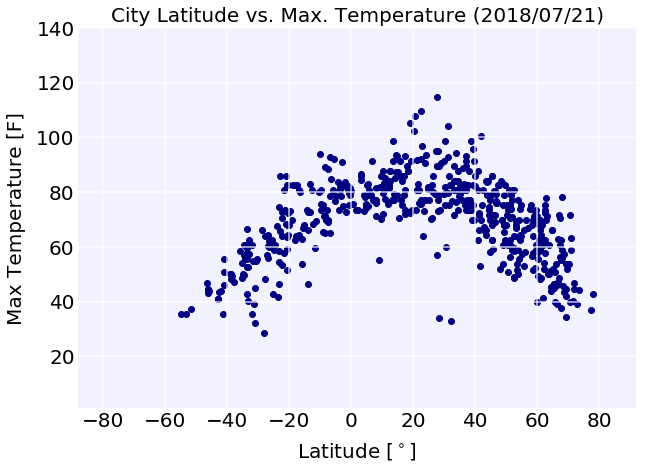

In [162]:
myfig = plt.figure(figsize=(10,7))
ax = plt.gca()
ax.patch.set_facecolor('blue')
ax.patch.set_alpha(0.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid(lw=2,color='white',alpha=0.6)

lat = df['lat']
temperature = df['temperature']
plt.scatter(lat,temperature,color='navy')
plt.xlim(-88,92)
plt.ylim(1,140)
plt.title('City Latitude vs. Max. Temperature (2018/07/21)',fontsize=20)
plt.ylabel('Max Temperature [F]',labelpad=10)
plt.xlabel('Latitude [$^\circ$]',labelpad=10)
plt.savefig('PyWeather-Temperature.png')

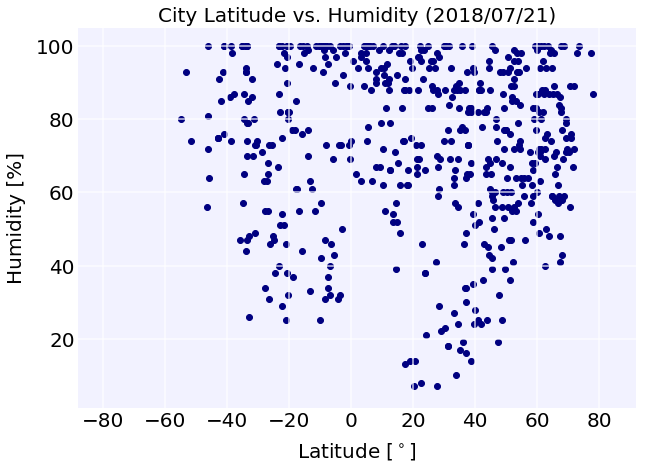

In [163]:
myfig = plt.figure(figsize=(10,7))
ax = plt.gca()
ax.patch.set_facecolor('blue')
ax.patch.set_alpha(0.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid(lw=2,color='white',alpha=0.6)

lat = df['lat']
humidity = df['humidity']
plt.scatter(lat,humidity,color='navy')
plt.xlim(-88,92)
plt.ylim(1,105)
plt.title('City Latitude vs. Humidity (2018/07/21)',fontsize=20)
plt.ylabel('Humidity [%]',labelpad=10)
plt.xlabel('Latitude [$^\circ$]',labelpad=10)
plt.savefig('PyWeather-Humidity.png')

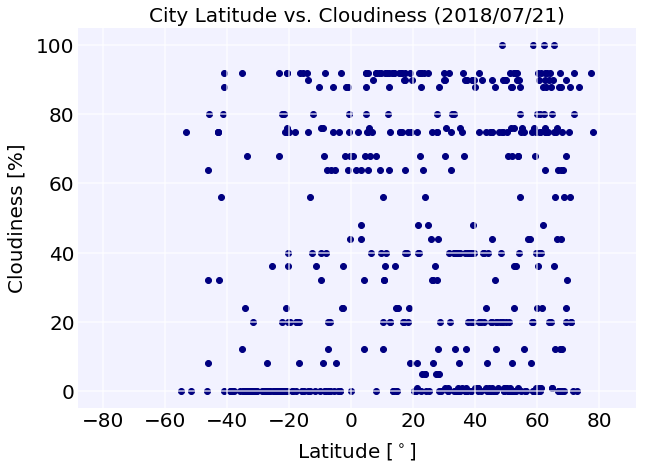

In [165]:
myfig = plt.figure(figsize=(10,7))
ax = plt.gca()
ax.patch.set_facecolor('blue')
ax.patch.set_alpha(0.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid(lw=2,color='white',alpha=0.6)

lat = df['lat']
cloudiness = df['cloudiness']
plt.scatter(lat,cloudiness,color='navy')
plt.xlim(-88,92)
plt.ylim(-5,105)
plt.title('City Latitude vs. Cloudiness (2018/07/21)',fontsize=20)
plt.ylabel('Cloudiness [%]',labelpad=10)
plt.xlabel('Latitude [$^\circ$]',labelpad=10)
plt.savefig('PyWeather-Cloudiness.png')

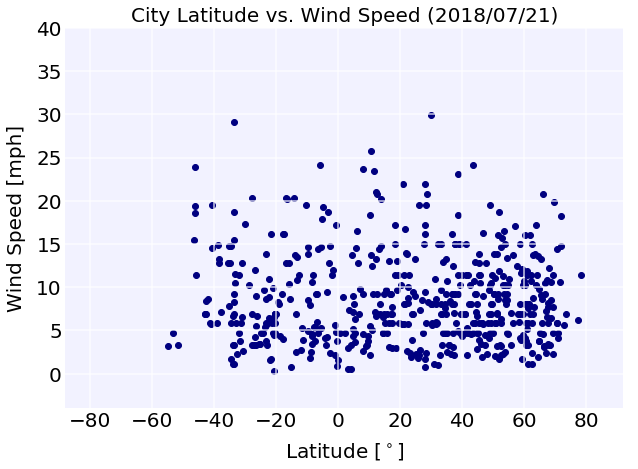

In [164]:
myfig = plt.figure(figsize=(10,7))
ax = plt.gca()
ax.patch.set_facecolor('blue')
ax.patch.set_alpha(0.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid(lw=2,color='white',alpha=0.6)

lat = df['lat']
windspeed = df['wind speed']
plt.scatter(lat,windspeed,color='navy')
plt.xlim(-88,92)
plt.ylim(-4,40)
plt.title('City Latitude vs. Wind Speed (2018/07/21)',fontsize=20)
plt.ylabel('Wind Speed [mph]',labelpad=10)
plt.xlabel('Latitude [$^\circ$]',labelpad=10)
plt.savefig('PyWeather-Windspeed.png')

In [176]:
xdf = df[ (df['lat'] > 0) & (df['lat'] < 40) & (df['temperature'] < 40)  ]
xdf.head(10)

,city,lon,lat,temperature,humidity,cloudiness,wind speed
41,gamba,88.52,28.28,34.05,97.0,88.0,2.37
252,manali,77.19,32.25,33.06,94.0,64.0,1.03
